# Pyroによる確率モデリング
https://pyro-book.data-hacker.net/docs/pyro_modeling/

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import pyro
import pyro.distributions as dist
from pyro import poutine
import torch

## 確率プリミティブ
一般的にベイズ学習において確率モデルは確率的に実現値が変動する「確率変数」の組み合わせで構成される。


Pyro上で確率変数を宣言するものが確率プリミティブ

In [9]:
x = pyro.sample("X",dist.Normal(0,1) ) #"X"を正規分布N(0,1)に従う確率変数として定義
x

tensor(-0.2359)

(array([   2.,    2.,   21.,   42.,  128.,  275.,  520.,  833., 1233.,
        1440., 1499., 1369., 1077.,  760.,  435.,  240.,   79.,   34.,
           9.,    2.]),
 array([-3.9515595 , -3.5670853 , -3.1826108 , -2.7981365 , -2.413662  ,
        -2.0291877 , -1.6447133 , -1.2602389 , -0.87576455, -0.49129018,
        -0.10681581,  0.27765855,  0.6621329 ,  1.0466073 ,  1.4310817 ,
         1.815556  ,  2.2000303 ,  2.5845048 ,  2.9689791 ,  3.3534536 ,
         3.737928  ], dtype=float32),
 <BarContainer object of 20 artists>)

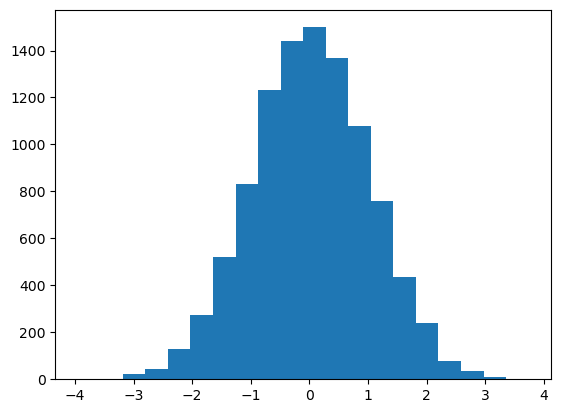

In [10]:
# for文によるサンプリング
x_list = []
for _ in range(10000):
    x = pyro.sample("X", dist.Normal(0,1))
    x_list.append(x)
plt.hist(x_list, bins=20)

var_type is <class 'torch.Tensor'>, shape = torch.Size([10000])


(array([1.000e+00, 4.000e+00, 9.000e+00, 4.200e+01, 8.600e+01, 2.260e+02,
        4.380e+02, 7.110e+02, 1.127e+03, 1.363e+03, 1.581e+03, 1.521e+03,
        1.155e+03, 8.380e+02, 4.690e+02, 2.610e+02, 1.070e+02, 4.700e+01,
        1.100e+01, 3.000e+00]),
 array([-4.1403027 , -3.7499309 , -3.3595588 , -2.969187  , -2.5788152 ,
        -2.1884432 , -1.7980714 , -1.4076995 , -1.0173275 , -0.6269557 ,
        -0.23658383,  0.15378806,  0.54415995,  0.9345318 ,  1.3249037 ,
         1.7152755 ,  2.1056476 ,  2.4960194 ,  2.8863912 ,  3.2767632 ,
         3.667135  ], dtype=float32),
 <BarContainer object of 20 artists>)

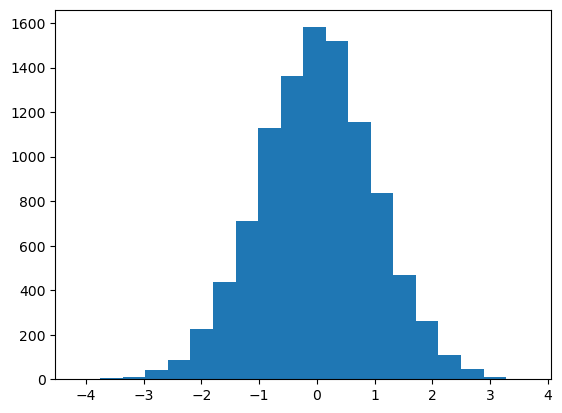

In [11]:
# plateを用いたサンプリング
with pyro.plate("plate1", size=10000):
    samples = pyro.sample("samples", dist.Normal(0,1))
print("var_type is {}, shape = {}".format(type(samples), samples.shape))
plt.hist(samples, bins=20)

## 確率モデルの宣言

確率モデルは、確率プリミティブの演算の組み合わせで構成されたpython関数として宣言

例：赤玉白玉問題

２つの袋a, bにそれぞれ

a:赤２個、白1個

b:赤１個、白３個

一つの袋から１つ玉を取り出す試行の例

In [13]:
def ball_model():
    x = pyro.sample("X", dist.Bernoulli(0.5))
    if x:
        y = pyro.sample("Y", dist.Bernoulli(2.0/3.0))
    else:
        y = pyro.sample("Y", dist.Bernoulli(1.0/4.0))
    return y

In [14]:
# 動作確認
for _ in range(5):
    print(ball_model())

tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(0.)


In [19]:
# 複雑な確率モデル
def geometric(p, t=None):
    if t is None:
        t = 0
    x = pyro.sample("x_{}".format(t), pyro.distributions.Bernoulli(p))
    if x.item() == 1:
        return 0
    else:
        return 1 - geometric(p, t+1)

In [20]:
print(geometric(0.5))

1


## エフェクト・ハンドラ　poutine

ベイズ推定では、確率モデルの挙動を記録したり、挙動を修正（条件付けなど）など、確率モデルをハンドリングする必要がある

そのようなハンドリング機能を担うのがpoutine

In [ ]:
traced_model = poutine.trace(model_fn) # TraceMessengerオブジェクトを取得
trace = traced_model.get_trace() # Traceオブジェクトを取得

In [24]:
tr = trace(ball_model).get_trace()
for tr_items in tr.nodes.items():
    print(tr_items)

('_INPUT', {'name': '_INPUT', 'type': 'args', 'args': (), 'kwargs': {}})
('loc', {'type': 'sample', 'name': 'loc', 'fn': Normal(loc: 0.0, scale: 1.0), 'is_observed': False, 'args': (), 'kwargs': {}, 'value': tensor(0.8274), 'infer': {}, 'scale': 1.0, 'mask': None, 'cond_indep_stack': (), 'done': True, 'stop': False, 'continuation': None})
('elasticity', {'type': 'sample', 'name': 'elasticity', 'fn': Uniform(low: 0.0, high: 2.0), 'is_observed': False, 'args': (), 'kwargs': {}, 'value': tensor(0.6646), 'infer': {}, 'scale': 1.0, 'mask': None, 'cond_indep_stack': (), 'done': True, 'stop': False, 'continuation': None})
('plate', {'type': 'sample', 'name': 'plate', 'fn': <pyro.poutine.subsample_messenger._Subsample object at 0x7f749358c790>, 'is_observed': False, 'args': (), 'kwargs': {}, 'value': tensor([0, 1, 2, 3, 4]), 'infer': {}, 'scale': 1.0, 'mask': None, 'cond_indep_stack': (), 'done': True, 'stop': False, 'continuation': None})
('position', {'type': 'sample', 'name': 'position', 'f

## 条件付　condition

conditionハンドラを用いてモデルないの各確率変数の実現値を固定（条件付）してサンプリングが可能

conditionハンドラを用いると、例えば、確率モデルのすべての確率変数の実現値を固定した上でサンプリングして、その確率を求めると同時確率を求められる


In [31]:
cond_dict = {"X":torch.tensor(1.), "Y":torch.tensor(1.)} # 袋a=1, 赤玉=1
conditioned_model = pyro.condition(ball_model, cond_dict)

tr = trace(conditioned_model).get_trace()
for tr_items in tr.nodes.items():
    print(tr_items)

print("p(X=1|Y=1) = ", tr.log_prob_sum().exp().item())

('_INPUT', {'name': '_INPUT', 'type': 'args', 'args': (), 'kwargs': {}})
('loc', {'type': 'sample', 'name': 'loc', 'fn': Normal(loc: 0.0, scale: 1.0), 'is_observed': False, 'args': (), 'kwargs': {}, 'value': tensor(1.0921), 'infer': {}, 'scale': 1.0, 'mask': None, 'cond_indep_stack': (), 'done': True, 'stop': False, 'continuation': None})
('elasticity', {'type': 'sample', 'name': 'elasticity', 'fn': Uniform(low: 0.0, high: 2.0), 'is_observed': False, 'args': (), 'kwargs': {}, 'value': tensor(0.4793), 'infer': {}, 'scale': 1.0, 'mask': None, 'cond_indep_stack': (), 'done': True, 'stop': False, 'continuation': None})
('plate', {'type': 'sample', 'name': 'plate', 'fn': <pyro.poutine.subsample_messenger._Subsample object at 0x7f7493401510>, 'is_observed': False, 'args': (), 'kwargs': {}, 'value': tensor([0, 1, 2, 3, 4]), 'infer': {}, 'scale': 1.0, 'mask': None, 'cond_indep_stack': (), 'done': True, 'stop': False, 'continuation': None})
('position', {'type': 'sample', 'name': 'position', 'f

# 確率分布の取り扱い

## 実現値のサンプリング

In [32]:
normal_1d = dist.Normal(0.0, 1.0)
print(normal_1d.sample())

tensor(-2.2510)


In [34]:
normal_2d = dist.MultivariateNormal(torch.zeros(2), torch.eye(2))
print(normal_2d.sample())

tensor([-1.5329, -0.2884])


In [36]:
# sample関数にtorch.Sizeを渡すことで、指定のshapeでサンプリング可能
normal_1d = dist.Normal(0.0, 1.0)
samples = normal_1d.sample(torch.Size([2,3]))
print(samples) # ここでサンプリングされた値間は独立同分布(IID)の関係にある

tensor([[-0.5000,  0.1641, -0.0962],
        [ 1.4317,  0.0978,  0.4371]])


In [38]:
x = pyro.sample("X", dist.Bernoulli(0.5))
print(x)

tensor(1.)


## 確率（密度）の取得
各確率分布において、指定された値が実現値となる確率を計算するには、log_prob関数を使用する

これは、対数確率密度を計算するため、生の確率密度値を計算する場合には、np.exp()を使用する

In [39]:
bel_dist = dist.Bernoulli(0.6)
x = torch.tensor([1.0, 0.0])
log_prob_x = bel_dist.log_prob(x)
print(np.exp(log_prob_x))

tensor([0.6000, 0.4000])


## batch_shapeとevent_shape

### batch_shape
確率分布のパラメータをTensor型で複数与えることで、同種の分布だが異なるパラメータで特徴づけられた複数の分布を同時に定義することができる

In [40]:
locs = torch.tensor([0.0, 3.0])
sds = torch.tensor([1.0, 0.5])
normal_1d_cond = dist.Normal(locs, sds)
print("batch_shape = ", normal_1d_cond.batch_shape)

batch_shape =  torch.Size([2])


samples.shape = torch.Size([10000, 2])


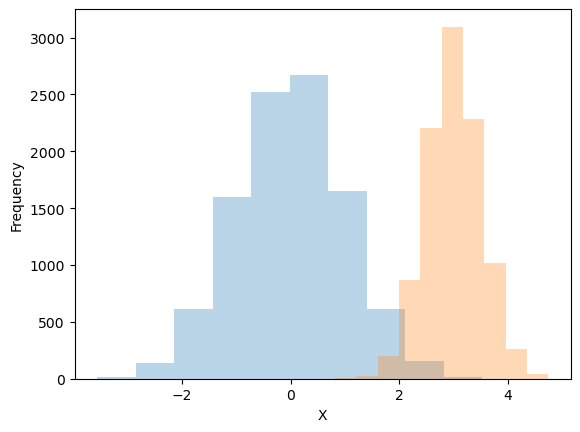

In [44]:
samples = normal_1d_cond.sample(torch.Size([10000]))
print("samples.shape =", samples.shape)

plt.hist(samples[:,0], alpha=0.3)
plt.hist(samples[:,1], alpha=0.3)
plt.xlabel("X")
plt.ylabel("Frequency")
plt.show()

In [45]:
log_prob_x = normal_1d_cond.log_prob(torch.Tensor([1.0]))
print(np.exp(log_prob_x))
print(log_prob_x.shape == normal_1d_cond.batch_shape)

tensor([0.2420, 0.0003])
True


### event_shape

Pyroの確率分布はevent_shapeという属性が設定される。

この属性は、確率分布の従属変数の数（＝サンプルされる実現値の次元数）が格納されている


In [46]:
# 二次元正規分布の例
normal_2d = dist.MultivariateNormal(torch.zeros(2), torch.eye(2))
sampled = normal_2d.sample()
print("(x, y)=", sampled)
print(normal_2d.event_shape)
print("P(x,y) =", np.exp(normal_2d.log_prob(sampled)))


(x, y)= tensor([-1.6056,  0.4872])
torch.Size([2])
P(x,y) = tensor(0.0389)


### 従属変数化 to_event()

In [47]:
ps = torch.Tensor([[0.3, 0.8], [0.1, 1.0]])
bern_dist = dist.Bernoulli(ps)
print("bern_dist.batch_shape =", bern_dist.batch_shape)

# 2*2=4つの異なるパラメータの確率分布それぞれのP(X=1)を計算
val = torch.Tensor([1.0])
print("P(X=1) =", np.exp(bern_dist.log_prob(val)))

bern_dist.batch_shape = torch.Size([2, 2])
P(X=1) = tensor([[0.3000, 0.8000],
        [0.1000, 1.0000]])


In [48]:
bern_dist2 = bern_dist.to_event(1)
print("bern_dist2.batch_shape = ", bern_dist2.batch_shape)
print("bern_dist2.event_shape = ", bern_dist2.event_shape)

val = torch.Tensor([1.0])
print("P(X=1) =", np.exp(bern_dist2.log_prob(val)))


bern_dist2.batch_shape =  torch.Size([2])
bern_dist2.event_shape =  torch.Size([2])
P(X=1) = tensor([0.2400, 0.1000])


# 変分推論の基礎

## おさらい

1. ベイズ学習とは、観測データ$\mathbf{X}$が得られたという条件下での未知のパラメータ$\mathbf{w}$の確率分布、すなわち$p(\mathbf{w}|\mathbf{x})$を学習する作業である。

2. 一般的にベイズ学習は①対象とする事象の生成過程を確率モデルとしてモデリングし、②確率モデルと観測データをもとに未知のパラメータを推論する、という枠組みで行う。

3. 条件付き確率の定義から、$\mathbf{W}$が離散変数の場合,$$p(\mathbf{w}|\mathbf{X})=\frac{p(\mathbf{w},\mathbf{X})}{p(\mathbf{X})}=\frac{p(\mathbf{w},\mathbf{X})}{\sum_{\mathbf{w}} p(\mathbf{w},\mathbf{X})}\tag{1}$$もしくは$\mathbf{W}$が連続変数の場合、$$
p(\mathbf{w}|\mathbf{X})=\frac{p(\mathbf{w},\mathbf{X})}{p(\mathbf{X})}=\frac{p(\mathbf{w},\mathbf{X})} {\int_{\mathbf{w}}p(\mathbf{w},\mathbf{X})d\mathbf{w}}\tag{2}$$を計算することで、$p(\mathbf{w}|\mathbf{X})$を推論する。